In [9]:
!pip install opencv-python pixellib torch torchvision
!pip install numpy==1.26.4

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


In [10]:
import cv2
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101
import matplotlib.pyplot as plt

print(cv2.__version__)
print(np.__version__)

4.11.0
1.26.4


윈터 이미지 크기: (2573, 1200, 3), 배경 이미지 크기: (194, 259, 3)


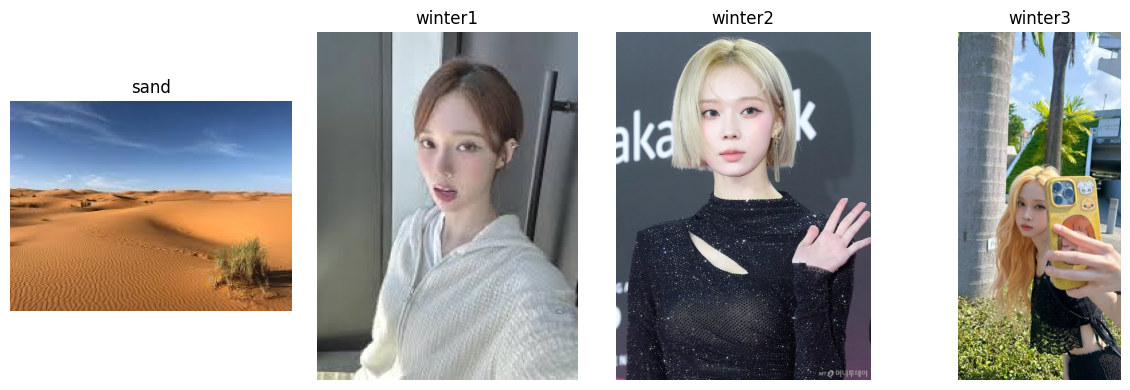

In [11]:
winter_img_paths = [
    "./data/winter_selfcamera1.jpg",
    "./data/winter_selfcamera2.jpg",
    "./data/winter_selfcamera3.jpg"
]
sand_img_path = "./data/sand.jpg"

winter_imgs = [cv2.imread(path) for path in winter_img_paths]
sand_img = cv2.imread(sand_img_path)

winter_imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in winter_imgs]
sand_img = cv2.cvtColor(sand_img, cv2.COLOR_BGR2RGB)
print(f'윈터 이미지 크기: {winter_imgs[2].shape}, 배경 이미지 크기: {sand_img.shape}')

def show_images(imgs, titles=None, cols=3, figsize=(12, 4)):
    n = len(imgs)
    rows = (n + cols - 1) // cols  # 필요한 행 개수
    plt.figure(figsize=figsize)

    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        if titles is not None and i < len(titles):
            plt.title(titles[i])
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_images([sand_img] + winter_imgs, titles=["sand", "winter1", "winter2", "winter3"], cols=4)

In [12]:
model = deeplabv3_resnet101(weights=True).eval()

transform = T.Compose([
    T.ToPILImage(),
    T.Resize((520, 520)),  # 모델 입력 크기
    T.ToTensor(),
])

In [13]:
def get_predictions(model, img):
    input_tensor = transform(img).unsqueeze(0)

    with torch.no_grad():
        output = model(input_tensor)["out"][0]
        output_predictions = output.argmax(0).byte().cpu().numpy()

    # print(f"추론 마스크 크기 (Before Resize): {output_predictions.shape}")

    return output_predictions

output_predictions = get_predictions(model, winter_imgs[1])

In [14]:
def resizing(predictions, img, ratio=1.0):
    new_width = int(img.shape[1] * ratio)
    new_height = int(img.shape[0] * ratio)
    output_predictions_resized = cv2.resize(
        predictions, (new_width, new_height), interpolation=cv2.INTER_NEAREST
    )

    # print(f"추론 마스크 크기 (After Resize): {output_predictions_resized.shape}")
    return output_predictions_resized

output_predictions_resized = resizing(output_predictions, winter_imgs[1])

In [15]:
def get_mask(predictions_resized):
    unique_classes = np.unique(predictions_resized)
    # print(f"예측된 클래스 ID: {unique_classes}")

    target_class_id = unique_classes[-1]
    
    seg_map = (predictions_resized == target_class_id)
    img_mask = seg_map.astype(np.uint8) * 255

    # plt.imshow(img_mask, cmap='gray')
    # plt.axis('off')
    # plt.show()

    return img_mask

img_mask = get_mask(output_predictions_resized)

In [16]:
def chromakey_img(img_background, img_target, img_mask, ratio=1.0):
    new_width = int(img_target.shape[1] * ratio)
    new_height = int(img_target.shape[0] * ratio)
    target_size = (new_width, new_height)

    img_target = cv2.resize(img_target, target_size)
    img_background = cv2.resize(img_background, target_size)
    img_mask = cv2.resize(img_mask, target_size)

    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)  # 3채널 변환
    result_img = np.where(img_mask_color == 255, img_target, img_background)  # 마스크 기반 합성

    # plt.imshow(result_img)
    # plt.axis('off')
    # plt.show()

    return result_img

result_img = chromakey_img(sand_img, winter_imgs[1], img_mask)

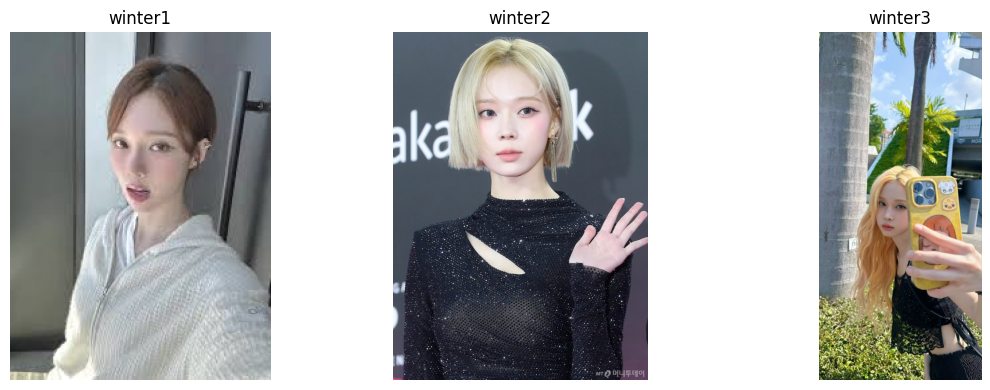

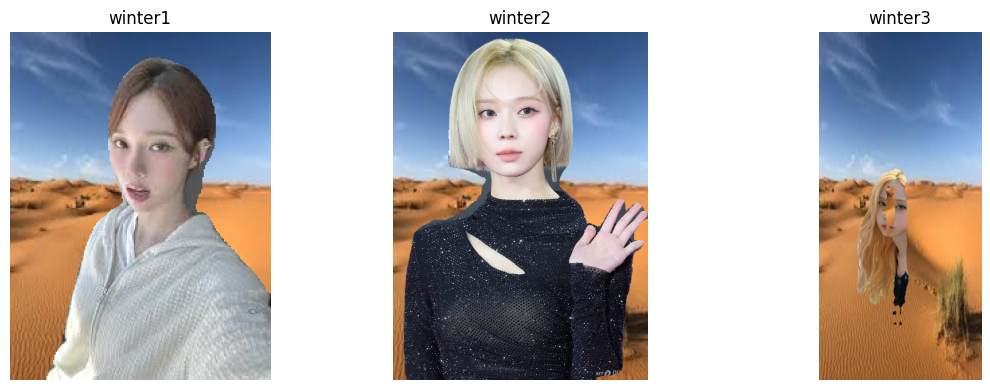

In [17]:
winter_mask_imgs = []
winter_result_imgs = []

for img in winter_imgs:
    output_predictions = get_predictions(model, img)
    output_predictions_resized = resizing(output_predictions, img)

    img_mask = get_mask(output_predictions_resized)
    winter_mask_imgs.append(img_mask)

    winter_result_imgs.append(chromakey_img(sand_img, img, img_mask))


show_images(winter_imgs, titles=["winter1", "winter2", "winter3"], cols=3)
show_images(winter_result_imgs, titles=["winter1", "winter2", "winter3"], cols=3)

- 1번: 목, 어깨 부분의 경계가 명확하게 segmenation되지 않음
- 2번: 원본 이미지의 글자로 인해 팔꿈치 부분이 segmentation되지 않음
- 3번: 원본 이미지의 대부분이 segmentation되지 않음

<img src="./first_output.png" width="1000"/>

- 이미지 하단 부분 crop

In [18]:
## 하단의 글씨 부분은 원본 이미지에 존재하는 노이즈로 가정하고 제거

def crop_bottom(img, crop_ratio=0.10):
    if img is None:
        raise ValueError("img is None")
    if not (0.0 <= crop_ratio < 1.0):
        raise ValueError("crop_ratio must be in [0.0, 1.0).")

    h = img.shape[0]
    cut = int(np.ceil(h * crop_ratio))  # 작아도 최소 1픽셀 이상 잘라지도록 올림
    if cut <= 0:
        return img.copy()

    return img[:h - cut, ...]  # 하단 cut 픽셀 제거 (2D/3D 모두 지원)

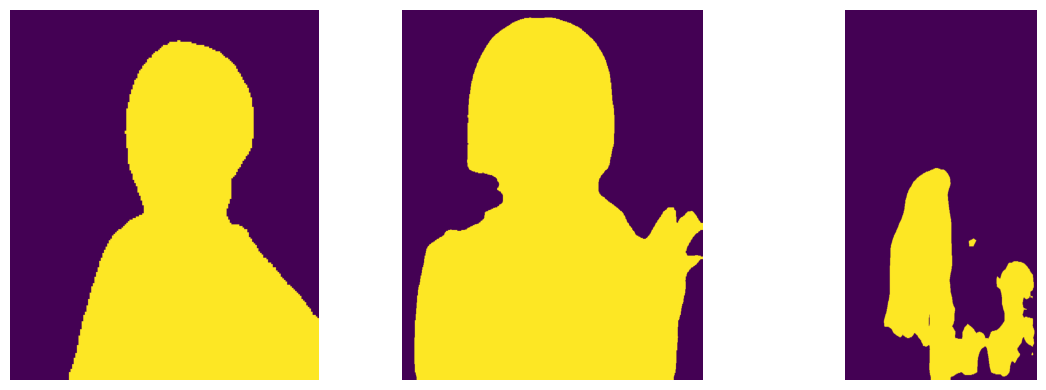

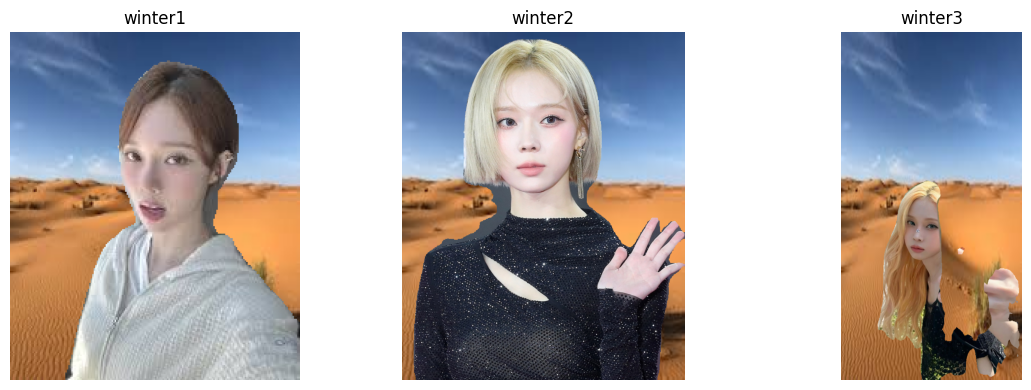

In [19]:
winter_mask_imgs = []
winter_result_imgs = []

for img in winter_imgs:
    img = crop_bottom(img, crop_ratio=0.10)

    output_predictions = get_predictions(model, img)
    output_predictions_resized = resizing(output_predictions, img)

    img_mask = get_mask(output_predictions_resized)
    winter_mask_imgs.append(img_mask)

    winter_result_imgs.append(chromakey_img(sand_img, img, img_mask))


show_images(winter_mask_imgs, cols=3)
show_images(winter_result_imgs, titles=["winter1", "winter2", "winter3"], cols=3)

- 2번 째 사진의 글자 부분, 3번 사진(전체적으로) 개선됨을 알 수 있음
- 3번 째 사진도 개선된 것을 보면, 긴 이미지를 (540, 540)으로 resizing하면서 데이터의 손실이 심한 것으로 보임
- 2번 째 사진의 목, 어깨 부분은 더 악화되었음. 정규화를 통해 옷(검정)과 배경(회색)을 더 잘 구분하도록 하는게 좋아보임

- size 변경, 정규화 (ImageNet mean, std 사용)

In [20]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

transform = T.Compose([
    T.ToPILImage(),
    # T.Resize((520, 520)),
    T.Resize((520, int(520*1.4))), # 인물 사진은 대부분 세로가 길기 때문에 세로를 더 길게
    T.ToTensor(),
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

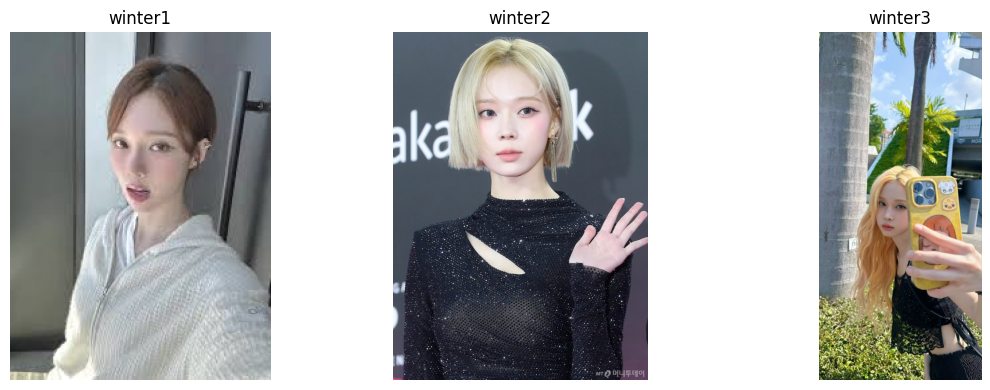

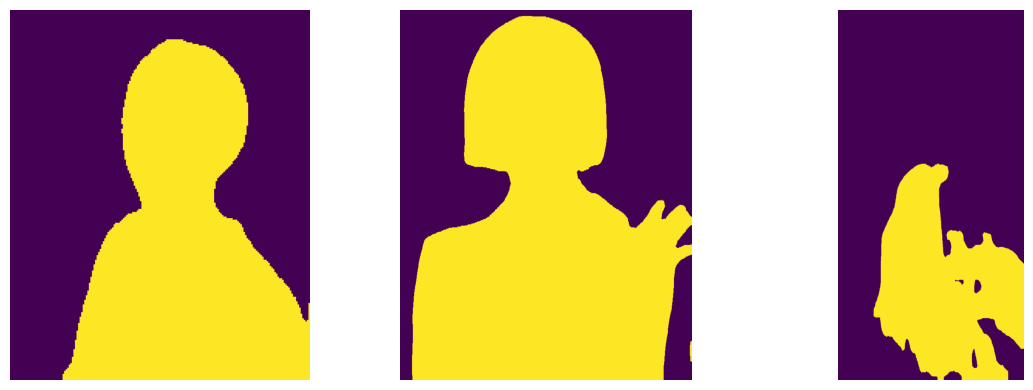

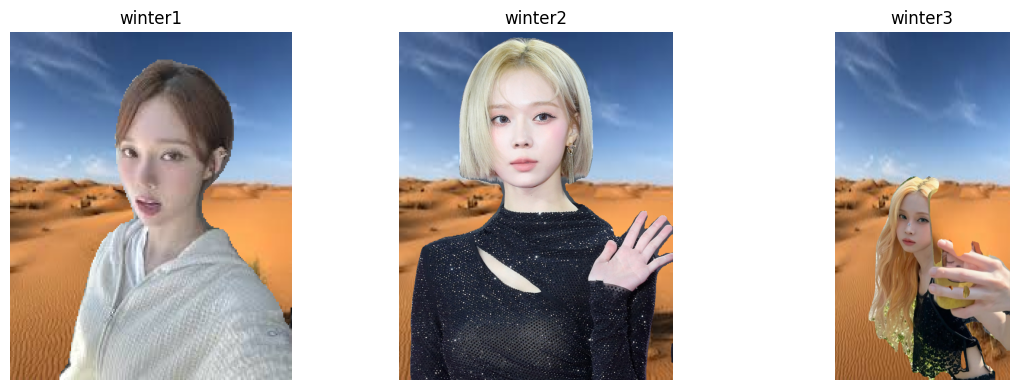

In [21]:
winter_mask_imgs = []
winter_result_imgs = []

for img in winter_imgs:
    img = crop_bottom(img, crop_ratio=0.07)

    output_predictions = get_predictions(model, img)
    output_predictions_resized = resizing(output_predictions, img)

    img_mask = get_mask(output_predictions_resized)
    winter_mask_imgs.append(img_mask)

    winter_result_imgs.append(chromakey_img(sand_img, img, img_mask))

show_images(winter_imgs, titles=["winter1", "winter2", "winter3"], cols=3)
show_images(winter_mask_imgs, cols=3)
show_images(winter_result_imgs, titles=["winter1", "winter2", "winter3"], cols=3)

- 3번째 사진의 핸드폰 부분을 제외하곤 완벽하게 segmentation이 되고있음

In [22]:
## + 배경 블러효과(아웃포커싱)

def blur_img(img_orig, img_mask):
    img_orig_blur = cv2.blur(img_orig, (25, 25))

    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)

    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)

    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
    return img_concat

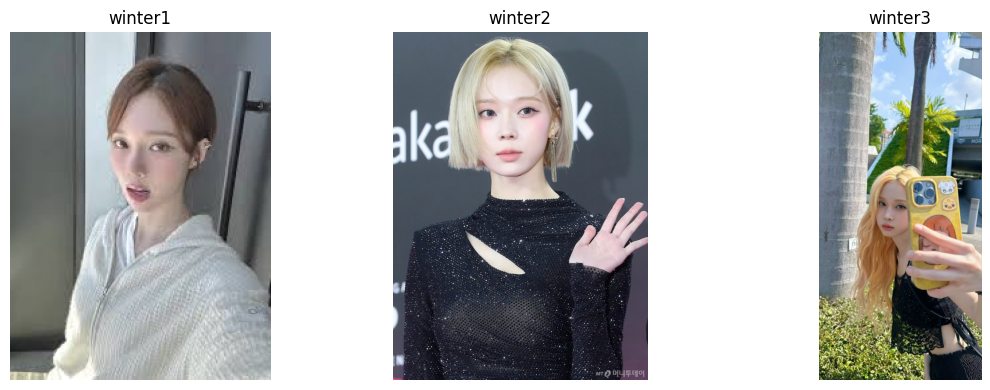

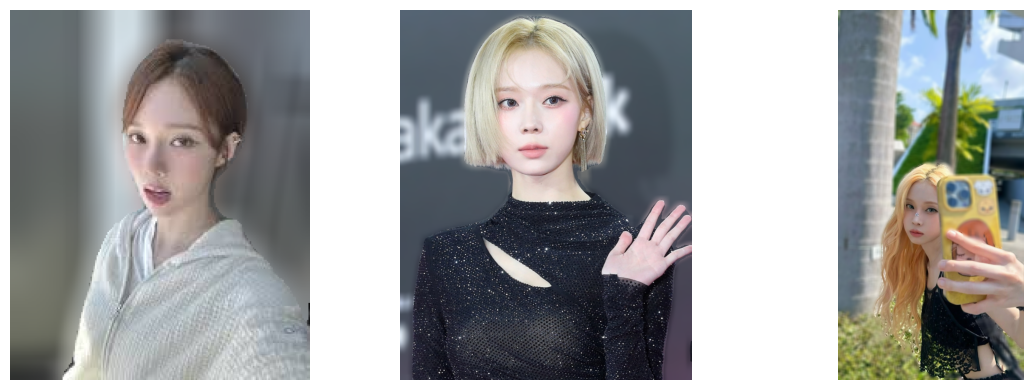

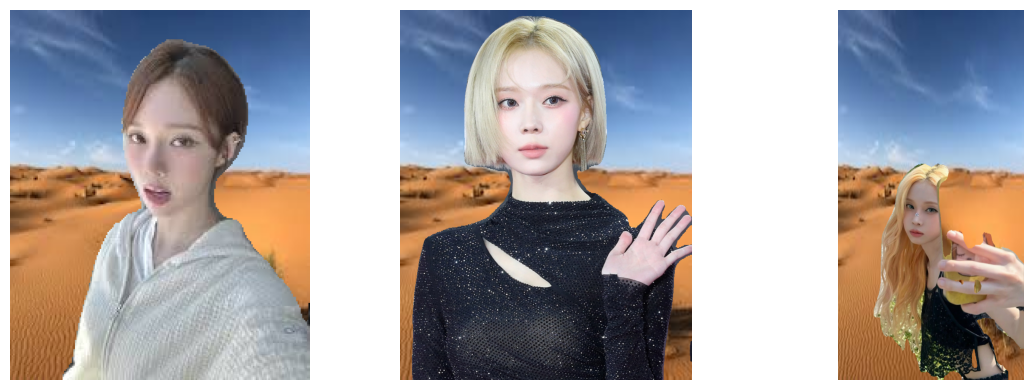

In [23]:
winter_blur_imgs = []
winter_chromakey_imgs = []

for img in winter_imgs:
    img = crop_bottom(img, crop_ratio=0.07)

    output_predictions = get_predictions(model, img)
    output_predictions_resized = resizing(output_predictions, img)

    img_mask = get_mask(output_predictions_resized)
    winter_mask_imgs.append(img_mask)

    winter_blur_imgs.append(blur_img(img, img_mask))
    winter_chromakey_imgs.append(chromakey_img(sand_img, img, img_mask))

show_images(winter_imgs, titles=["winter1", "winter2", "winter3"], cols=3)
show_images(winter_blur_imgs, cols=3)
show_images(winter_chromakey_imgs, cols=3)